In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt

from mpmath import polylog

from sklearn.model_selection import train_test_split

In [2]:
def generate_data(func, lower=0, upper=1, n_samples=100):
    """
        Generates data in the form of a 2D (1D in case if the function 
        is single-variable) tensor of variables for fuction and neural network input
        as well as te function values for the generated tensor of variables.

        @param func      function to provide values for the variables
        @param lower     lower bound of variables
        @param upper     upper bound of variables
        @param n_samples number of points of data to generate
                         (default value is 100)

        @returns         variables x and function values y
    """
    x = torch.linspace(lower, upper, n_samples).view(n_samples, 1) # 1 for 1d functions
    y = func(x)
    
    return x, y

In [3]:
class MLP(nn.Module):
    """
        Нейросеть, которая будет обучаться приближать функцию одной переменной.
        
        Нейросеть имеет архитектуру:

        Входной слой (1 нейрон для переменной функции + смещение, линейная функция активации)
        Скрытый слой (произвольное количество нейронов + смещение, функция активации - сигмоида)
        Выходной слой (1 нейрон для приближенного значения функции, линейная функция активации)
    """
    def __init__(self, hidden_size):
        """
            Конструктор для нейросети.
            @param self        нейросеть (необходим для включения в класс)
            @param hidden_size размер скрытого слоя (размеры входного и выходного слоёв равны одному
                               в рамках данной задачи, так как у функции одна переменная и 
                               задача сводится к описанию функции, то есть числа, скаляра).
        """
        super(MLP, self).__init__()
        self.input_hidden_layer = nn.Linear(1, hidden_size) # инициализация входного и скрытого слоя, 
                                                     # размеры: 1 --> размер скрытого слоя
        self.sigmoid_activation = nn.Sigmoid() # инициализация функции активации скрытого слоя
        self.output_layer = nn.Linear(hidden_size, 1) # инициализация выходного слоя, 
                                                      # размеры: размер скрытого слоя --> 1
    
    def forward(self, x):
        """
            Функция распространения данных через нейросеть вперёд.
           
            @param self   нейросеть (необходим для включения в класс)
            @param x      данные
           
            @returns выход в выходном нейроне
        """
        x = self.input_hidden_layer(x) # данные прошли входной слой и аккумулирвоаны в скрытом слое
        x = self.sigmoid_activation(x) # данные прошли функцию активации скрытого слоя
        x = self.output_layer(x) # данные прошли выходной слой
        
        return x


def train_model(model, criterion, optimizer, x_train, y_train, epochs):
    """
        Trains the model.
        
        @param model        The model to be trained
        @param criterion    Loss function
        @param optimizer    Optimization algorithm
        @param x_train      Training inputs
        @param y_train      True labels
        @param epochs       Number of training epochs
    """
    loss_history = [] # история обучения (изменения функции потерь)
    for epoch in range(epochs):
        predictions = model(x_train) # все переменные проводятся через нейросеть 
                                     # и формируются предскзания значений функции
        loss = criterion(predictions, y_train) # вычисляется функция потерь на данной эпохе

        optimizer.zero_grad() # обнуляются градиенты перед обратным распространением ошибки
        loss.backward() # обратное распространение ошибки
        optimizer.step() # шаг оптимизации - обновление параметров модели 

        loss_history.append(loss.item()) # запись текущей функции потерь

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.10f}') # вывод информации об обучении
    
    return loss_history # возвращается история обучения


def test_model(model, criterion, x_test, y_test):
    """
        Tests the model.
        
        @param model        The trained model
        @param criterion    Loss function
        @param x_test       Test inputs
        @param y_test       True labels
    """
    with torch.no_grad():  # отключение расчета градиентов 
                           # (расчет градиентов может происходить по умолчанию 
                           # даже без использования их потом, что излишне нагружает память)
        predictions = model(x_test)  # тестовые переменные проводятся через обученную модель
        loss = criterion(predictions, y_test)  # вычисляется функция потерь для тестового набора

    # Возвращаем вычисленную функцию потерь
    return loss.item()  # Возвращаем скалярное значение ошибки


def predict_with_model(model, x_test):
    """
        Uses the model to predict values based on x_test arguments.
    
        @param model        The trained model
        @param x_test       Test inputs
    """
    with torch.no_grad():
        predictions = model(x_test)

    return predictions


def extract_model_params(model):
    """
        Функция извлечения параметров нейросети.
        @param model модель, из которой необходимо извлеч параметры
        @returns 4 объекта типа numpy.array: смещения 1-го слоя, веса 1-го слоя,
                 смещения 2-го слоя, веса 2-го слоя
    """
    # detach() - возвращает выбранный параметр, numpy() конвертирует в формат numpy.array,
    # flatten() для весов преобразует векторы-столбцы в векторы-строки.
    b1 = model.input_hidden_layer.bias.detach().numpy() 
    w1 = model.input_hidden_layer.weight.detach().numpy().flatten()
    b2 = model.output_layer.bias.detach().numpy() 
    w2 = model.output_layer.weight.detach().numpy().flatten()
    
    return b1, w1, b2, w2

# Integration function

In [4]:
def get_NN_integral(alpha, beta, b1, w1, b2, w2):
    """
        Функция, реализующая метод численного интегрирования функции одной переменной
        на основе параметров нейросети. Реализует формулы (6.1) и (6.2).

        @param alpha нижняя граница интегрирования
        @param beta  верхняя граница интегрирования
        @param b1    смещения между входным и скрытым слоями
        @param w1    веса между входным и скрытым слоями
        @param b2    смещения между скрытым и выходным слоями
        @param w2    веса между скрытым и выходным слоями

        @returns численный интеграл на основе параметров нейросети.
    """
    def Phi_j(alpha, beta, b1_j, w1_j):
        """
            Вложенная функция, реализующая разность полилогарифмов (6.2).

            @param alpha нижняя граница интегрирования
            @param beta  верхняя граница интегрирования
            @param b1_j  j-е смещение между входным и скрытым слоями
            @param w1_j  j-тый вес между входным и скрытым слоями

            @returns разность полилогарифмов (6.2)
        """
        term_alpha = polylog(1, -np.exp(-b1_j - w1_j * alpha)) # расчет первого полилогарифма 1-го порядка
        term_beta = polylog(1, -np.exp(-b1_j - w1_j * beta)) # расчет второго полилогарифма 1-го порядка
        
        return term_alpha - term_beta # результат - разность первого и второго полилогарифмов

    integral_sum = 0 # сумма интеграллов 
    
    for w2_j, w1_j, b1_j in zip(w2, w1, b1):
        phi_j = Phi_j(alpha, beta, b1_j, w1_j) # рассчет разности полилогарифмов (6.2)
        integral_sum += w2_j * ((beta - alpha) + phi_j / w1_j) # аккумулирование интегралла для суммы в (6.1)
    
    return b2 * (beta - alpha) + integral_sum # результат полная формула численног метода (6.1)

# Physics task: Definition

\begin{equation}
    \int_{0}^{1}d\alpha\{\alpha^{a}(1 - \alpha)^b\}\int_{0}^{\infty}dt\{\frac{t^m}{(1+t)^n}F[z_{0}]\} \equiv I(a, b, m, n; F[z_{0}])  \tag{1}
\end{equation}
\begin{equation}   
    F[z_0] = \exp[-2z_0]  \tag{2}
\end{equation}
\begin{equation} 
    z_0 = tD + \frac{t}{1 + t}R^2  \tag{3}
\end{equation}
\begin{equation}     
    D = \alpha_1(b_1^{2}P^2 + m_1^2) + \alpha_2(b_2^{2}P^2 + m_2^2)  \tag{4}
\end{equation}
\begin{equation} 
        R^2 = (\alpha_1^{2}b_1^2 + \alpha_2^{2}b_2^2 + 2\alpha_{1}\alpha_{2}b_{1}b_2)P^2  \tag{5}
\end{equation}
\begin{equation} 
    b_1 = -\frac{m_1}{m_1 + m_2}  \tag{6}
\end{equation}
\begin{equation} 
    b_2 = \frac{m_2}{m_1 + m_2}  \tag{7}
\end{equation}
\begin{equation} 
    m_1 = m_2 = 0.7083333, P^2 = -1.665046  \tag{8}
\end{equation}

## Constants: general

These constants will be used for all of the calculations.

In [5]:
la = 0.8550000
# la = 1/137
alpha1 = alpha2 = la
m1 = 0.7083333
m2 = 0.7083333
PP = -1.665046

## First factor function

\begin{equation}
    \alpha^{a}(1 - \alpha)^b\ \tag{1.1}
\end{equation}

In [6]:
def alpha_func(alpha):
    return alpha ** a * (1 - alpha) ** b

## Second factor function

\begin{equation}
   \frac{t^m}{(1+t)^n}F[z_{0}]  \tag{1.2}
\end{equation}

As far as the integral function converges quickly the infinite upper bound of integration will be replaced with a constant. Later we will decide which constant to choose.

In [7]:
def b1_func():
    return - m1 / (m1 + m2)

def b2_func():
    return m2 / (m1 + m2)

def D_func():
    b1b1 = b1_func() ** 2
    b2b2 = b2_func() ** 2
    
    return alpha1 * (b1b1 * PP + m1**2) + alpha2 * (b2b2 * PP + m2**2)

def RR_func():
    b1 = b1_func()
    b2 = b2_func()
    b1b1 = b1 ** 2
    b2b2 = b2 ** 2
    
    return (alpha1**2 * b1b1 + alpha2**2 * b2b2 + 2 * alpha1 * alpha2 * b1 * b2) * PP

def z0_func(t):
    D = D_func()
    RR = RR_func()
    return t * D + t / (1 + t) * RR

def F_func(t):
    z_0 = z0_func(t)
    return np.exp(-2*z_0)

def t_func(t):
    return (t ** m) / ((1 + t) ** n) * F_func(t)

## Second factor function: addition

The further computation will require a derivative of the (2) function, so it should be declared here. The derivative is equal to

\begin{equation}
    F'[z_0] = -2\exp[-2z_0] \tag{9}
\end{equation}

In [8]:
def F_derivative(t):
    return -2 * F_func(t)

def t_func_with_F_der(t):
    return t ** m / (1 + t) ** n * F_derivative(t)    

# NN Integration: first run

The constants are:

In [9]:
a = 0
b = 1
m = 2
n = 2

## Dataset (1.1)

In [10]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=0, upper=1, n_samples=1000)

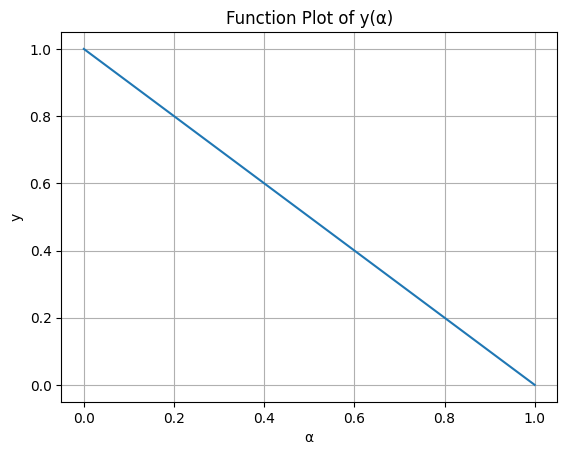

In [11]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

## Dataset (1.2)

In [12]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

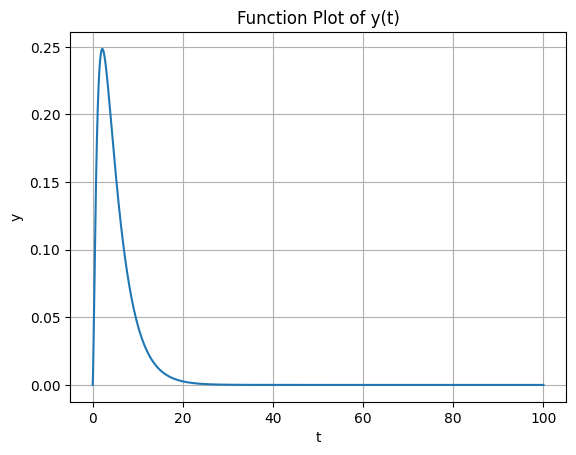

In [13]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

### Dataset (1.2) optimization

In [14]:
T, t_y = generate_data(func=t_func, lower=0, upper=25, n_samples=2500)

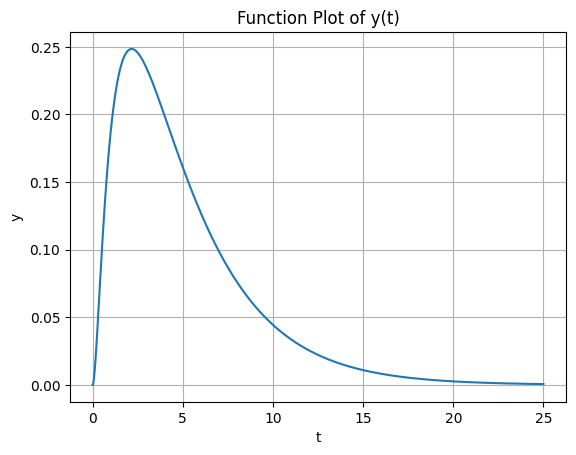

In [15]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

Now let's find the point at which the $y(t)$ stops to change rapidly $|y(t_i) - y(t_{i+1})| < \epsilon)$. This $t_i$ is going to be the upper bound of the integration.

In [16]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

In [17]:
def find_upper_bound(X, y, epsilon, points_limit=1, lower_index=0):
    """
        Finds the upper bound of integration. In this case a point, 
        where the next function value is greater/lesser than the previous
        less than a given threshold.

        @param X            variable values
        @param y            function values
        @param epsilon      threshold
        @param points_limit limit of bound points number 
        @param lower_index  starting X value for the search
        
        @returns       the required variable values (can be many) 
                       or empty list if none found
    """
    X_points = []
    
    if len(X) != len(y):
        raise ValueError("There numbers of variable and function values are inequal!")
    
    for i in range(lower_index, len(y) - 1):
        diff = torch.abs(y[i] - y[i + 1])
        if diff < epsilon:
            X_points.append(X[i])
        if len(X_points) == points_limit:
            break
            
    return X_points

In [18]:
upper_bound_t = find_upper_bound(X=T, y=t_y, epsilon=0.0000001, points_limit=1, lower_index=2000) # the 2000 value should be around t=20 based on graph
upper_bound_t

[tensor([34.9635])]

We see that function $y(t)$ should be integrated within bounds $[0, $ upper_bound_t$]$

### Final dataset (1.2)

In [19]:
up = upper_bound_t[0].item()
T, t_y = T, t_y = generate_data(func=t_func, lower=0, upper=upper_bound_t[0].item(), n_samples=int(up*100))

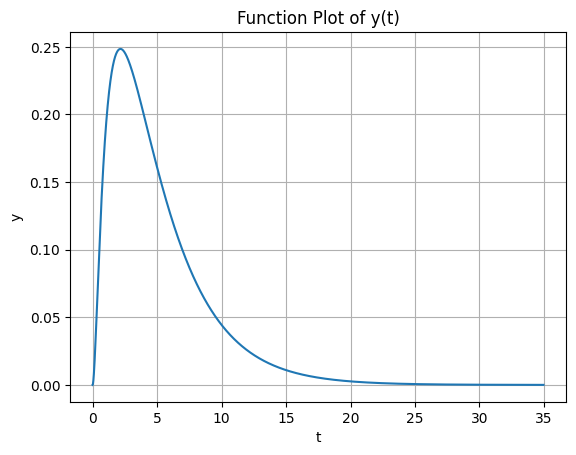

In [20]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Integration bounds

$a_1, b_1$ for (1.1), $a_2, b_2$ for (1.2).

In [21]:
a1 = 0.0000000
b1 = 1.0000000
a2 = 0.0000000
# a2 = 2.0000000
b2 = upper_bound_t[0].item() # item for extracting float value from torch.Tensor type
# b2 = 12.0000000

a1, a2, b1, b2

(0.0, 0.0, 1.0, 34.963497161865234)

## Datasets based on bounds

In [22]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=a1, upper=b1, n_samples=1000)
T, t_y = T, t_y = generate_data(func=t_func, lower=a2, upper=b2, n_samples=int(up*100))

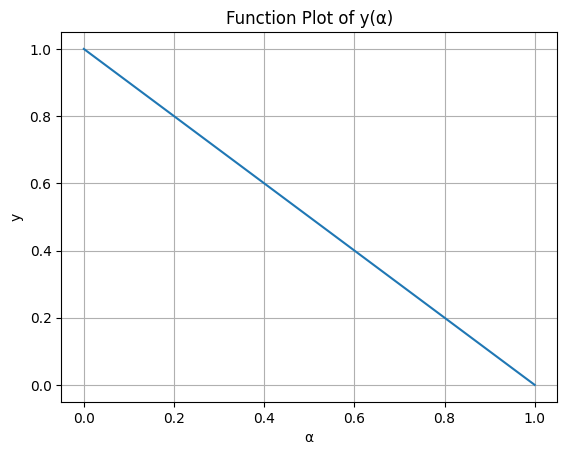

In [23]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

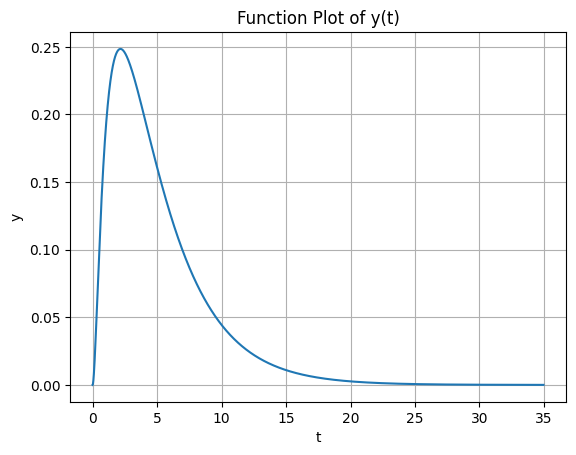

In [24]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

In [25]:
# def normalize(X, y):
#     X_min = X.min()
#     X_max = X.max()
#     X_norm = (X - X_min) / (X_max - X_min)

#     y_min = y.min()
#     y_max = y.max()
#     y_norm = (y - y_min) / (y_max - y_min)

#     return X_norm, y_norm

In [26]:
# T, t_y = normalize(T, t_y)

In [27]:
# T_np = T.numpy()
# t_y_np = t_y.numpy()
# plt.plot(T_np, t_y_np)
# plt.xlabel('t')
# plt.ylabel('y')
# plt.title('Function Plot of y(t)')
# plt.grid(True)
# plt.show()

## Train-test datasets split

In [28]:
alpha_train, alpha_test, ya_train, ya_test = train_test_split(Alpha, alpha_y, test_size=0.1) # 10% from Lloyd's at all. "Using..."
t_train, t_test, yt_train, yt_test = train_test_split(T, t_y, test_size=0.1)

In [29]:
alpha_train.shape, alpha_test.shape, ya_train.shape, ya_test.shape

(torch.Size([900, 1]),
 torch.Size([100, 1]),
 torch.Size([900, 1]),
 torch.Size([100, 1]))

In [30]:
t_train.shape, t_test.shape, yt_train.shape, yt_test.shape

(torch.Size([3146, 1]),
 torch.Size([350, 1]),
 torch.Size([3146, 1]),
 torch.Size([350, 1]))

## Model 1 (alpha_model)

### Hyperparams for the NN alpha_model (for function 1.1)

In [31]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 10000

### alpha_model definition, compilation and training

In [32]:
alpha_model = MLP(hidden_size)

criterion = nn.MSELoss()
alpha_optimizer = optim.Adam(alpha_model.parameters(), lr=learning_rate)

alpha_train_history = train_model(alpha_model, criterion, alpha_optimizer, alpha_train, ya_train, num_epochs)

summary(alpha_model, (1,)) # (1, ) - input shape

Epoch [100/10000], Loss: 0.0853889734
Epoch [200/10000], Loss: 0.0756037757
Epoch [300/10000], Loss: 0.0661687031
Epoch [400/10000], Loss: 0.0564945228
Epoch [500/10000], Loss: 0.0462295040
Epoch [600/10000], Loss: 0.0354668759
Epoch [700/10000], Loss: 0.0248640794
Epoch [800/10000], Loss: 0.0154900635
Epoch [900/10000], Loss: 0.0083662895
Epoch [1000/10000], Loss: 0.0038673093
Epoch [1100/10000], Loss: 0.0015521984
Epoch [1200/10000], Loss: 0.0005849777
Epoch [1300/10000], Loss: 0.0002525066
Epoch [1400/10000], Loss: 0.0001553191
Epoch [1500/10000], Loss: 0.0001290810
Epoch [1600/10000], Loss: 0.0001207233
Epoch [1700/10000], Loss: 0.0001161652
Epoch [1800/10000], Loss: 0.0001122540
Epoch [1900/10000], Loss: 0.0001083931
Epoch [2000/10000], Loss: 0.0001044935
Epoch [2100/10000], Loss: 0.0001005548
Epoch [2200/10000], Loss: 0.0000965880
Epoch [2300/10000], Loss: 0.0000926059
Epoch [2400/10000], Loss: 0.0000886217
Epoch [2500/10000], Loss: 0.0000846481
Epoch [2600/10000], Loss: 0.000080

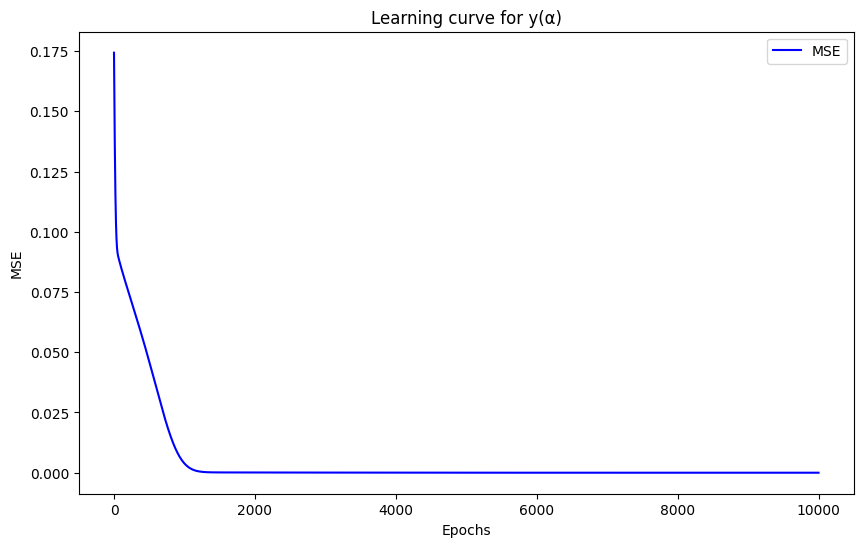

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(α)')
plt.legend()
plt.grid(False)
plt.show()

### alpha_model testing

In [34]:
alpha_test_loss = test_model(alpha_model, criterion, alpha_test, ya_test)
print(f"Test Loss: {alpha_test_loss:.10f}")

Test Loss: 0.0000055746


## alpha_model usage

In [35]:
bs1, we1, bs2, we2 = extract_model_params(alpha_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [36]:
nn_alpha = get_NN_integral(a1, b1, bs1, we1, bs2, we2)

nn_alpha

array([mpf('0.49993506217291239')], dtype=object)

It's easy to get this integral analytically $\int d\alpha \{1 - \alpha\} = \alpha - \frac{\alpha^2}{2}$, so the actual definite integral value is:

In [37]:
def int_alpha(a, b):
    return b - b**2/2 - (a - a**2/2)

alpha_actual = int_alpha(0, 1)

alpha_actual

0.5

And the error is:

In [38]:
nn_alpha = float(nn_alpha[0]) # since there should be one value of the definite integral

abs(nn_alpha - alpha_actual)

6.493782708760776e-05

## Model 2 (t_model)

### Hyperparams for the NN t_model (for function 1.2)

In [39]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### t_model definition, compilation and training

In [40]:
t_model = MLP(hidden_size)

criterion = nn.MSELoss()
t_optimizer = optim.Adam(t_model.parameters(), lr=learning_rate)

t_train_history = train_model(t_model, criterion, t_optimizer, t_train, yt_train, num_epochs)

summary(t_model, (1,)) # (1, ) - input shape

Epoch [100/5000], Loss: 0.0363627002
Epoch [200/5000], Loss: 0.0025994652
Epoch [300/5000], Loss: 0.0019888123
Epoch [400/5000], Loss: 0.0016741095
Epoch [500/5000], Loss: 0.0014638102
Epoch [600/5000], Loss: 0.0012913645
Epoch [700/5000], Loss: 0.0011373744
Epoch [800/5000], Loss: 0.0009897266
Epoch [900/5000], Loss: 0.0008428979
Epoch [1000/5000], Loss: 0.0006982911
Epoch [1100/5000], Loss: 0.0005592310
Epoch [1200/5000], Loss: 0.0004275859
Epoch [1300/5000], Loss: 0.0003073248
Epoch [1400/5000], Loss: 0.0002051950
Epoch [1500/5000], Loss: 0.0001273583
Epoch [1600/5000], Loss: 0.0000750930
Epoch [1700/5000], Loss: 0.0000436947
Epoch [1800/5000], Loss: 0.0000260614
Epoch [1900/5000], Loss: 0.0000163491
Epoch [2000/5000], Loss: 0.0000108980
Epoch [2100/5000], Loss: 0.0000076933
Epoch [2200/5000], Loss: 0.0000056903
Epoch [2300/5000], Loss: 0.0000043587
Epoch [2400/5000], Loss: 0.0000034261
Epoch [2500/5000], Loss: 0.0000027463
Epoch [2600/5000], Loss: 0.0000022354
Epoch [2700/5000], Lo

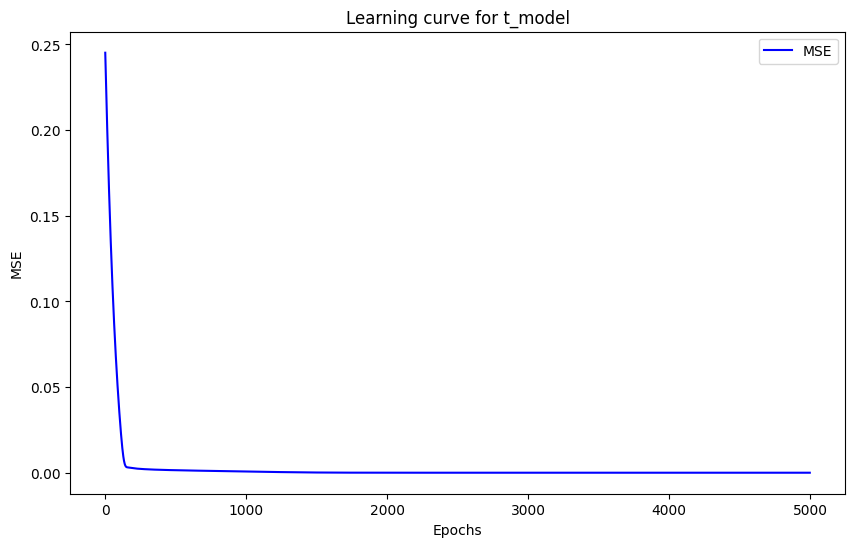

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(t_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for t_model')
plt.legend()
plt.grid(False)
plt.show()

### t_model testing

In [42]:
t_test_loss = test_model(t_model, criterion, t_test, yt_test)
print(f"Test Loss: {t_test_loss:.10f}")

Test Loss: 0.0000002058


## t_model usage

In [43]:
bs1, we1, bs2, we2 = extract_model_params(t_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [44]:
nn_t = get_NN_integral(a2, b2, bs1, we1, bs2, we2)

nn_t

array([mpf('1.5805569236122725')], dtype=object)

In [45]:
nn_t = float(nn_t[0])

## Result 1

In [46]:
result1 = nn_alpha * nn_t

result1

0.7901758238739286

In [47]:
correct_result1 = 0.7724590
error_for_result1 = abs(result1 - correct_result1)
error_for_result1

0.01771682387392859

# NN Integration: second run

The constants are:

In [48]:
a = 0
b = 1
m = 3
n = 3

## Dataset (1.1)

In [49]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=0, upper=1, n_samples=1000)

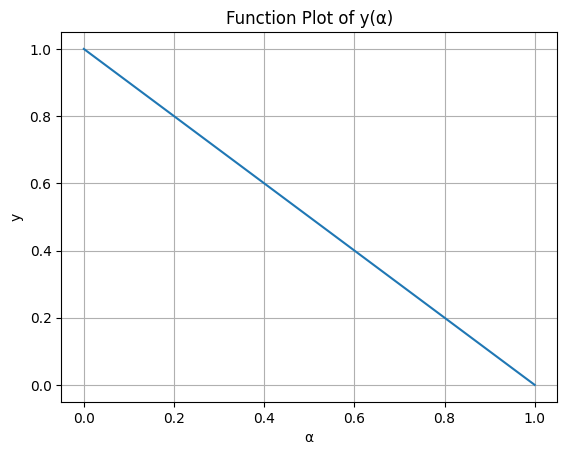

In [50]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

## Dataset (1.2)

In [51]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

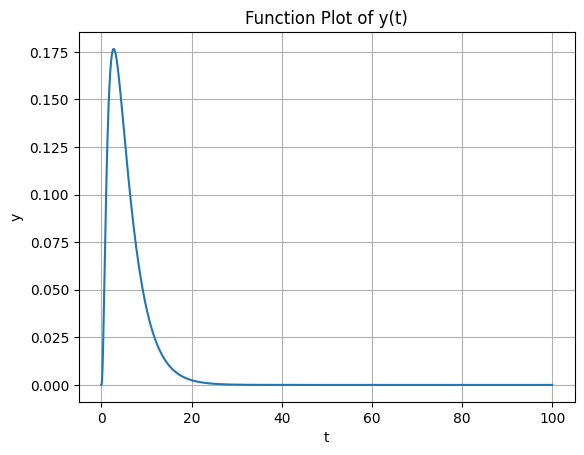

In [52]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

### Dataset (1.2) optimization

In [53]:
T, t_y = generate_data(func=t_func, lower=0, upper=40, n_samples=4000)

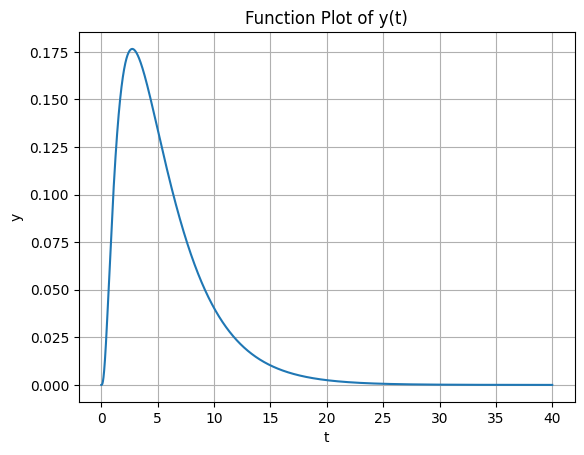

In [54]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

Now let's find the point at which the $y(t)$ stops to change rapidly $|y(t_i) - y(t_{i+1})| < \epsilon)$. This $t_i$ is going to be the upper bound of the integration.

In [55]:
T, t_y = generate_data(func=t_func, lower=0, upper=100, n_samples=10000)

In [56]:
def find_upper_bound(X, y, epsilon, points_limit=1, lower_index=0):
    """
        Finds the upper bound of integration. In this case a point, 
        where the next function value is greater/lesser than the previous
        less than a given threshold.

        @param X            variable values
        @param y            function values
        @param epsilon      threshold
        @param points_limit limit of bound points number 
        @param lower_index  starting X value for the search
        
        @returns       the required variable values (can be many) 
                       or empty list if none found
    """
    X_points = []
    
    if len(X) != len(y):
        raise ValueError("There numbers of variable and function values are inequal!")
    
    for i in range(lower_index, len(y) - 1):
        diff = torch.abs(y[i] - y[i + 1])
        if diff < epsilon:
            X_points.append(X[i])
        if len(X_points) == points_limit:
            break
            
    return X_points

In [57]:
upper_bound_t = find_upper_bound(X=T, y=t_y, epsilon=0.0000001, points_limit=1, lower_index=2000) # the 2000 value should be around t=20 based on graph
upper_bound_t

[tensor([34.8535])]

We see that function $y(t)$ should be integrated within bounds $[0, $ upper_bound_t$]$

### Final dataset (1.2)

In [58]:
up = upper_bound_t[0].item()
T, t_y = T, t_y = generate_data(func=t_func, lower=0, upper=upper_bound_t[0].item(), n_samples=int(up*100))

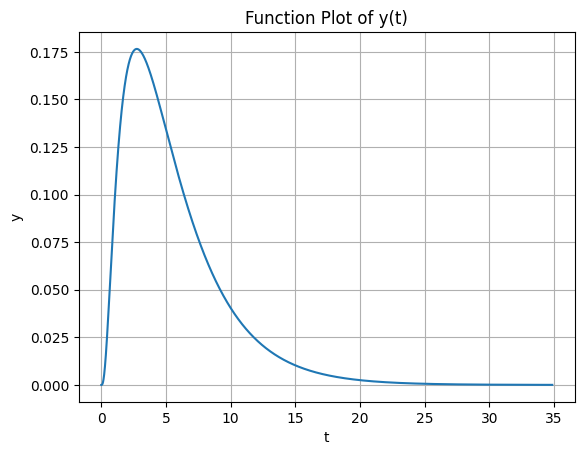

In [59]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

## Integration bounds

$a_1, b_1$ for (1.1), $a_2, b_2$ for (1.2).

In [60]:
a1 = 0.0000000
b1 = 1.0000000
a2 = 0.0000000
# a2 = 2.0000000
b2 = upper_bound_t[0].item() # item for extracting float value from torch.Tensor type
# b2 = 12.0000000

a1, a2, b1, b2

(0.0, 0.0, 1.0, 34.853485107421875)

## Datasets based on bounds

In [61]:
Alpha, alpha_y = generate_data(func=alpha_func, lower=a1, upper=b1, n_samples=1000)
T, t_y = T, t_y = generate_data(func=t_func, lower=a2, upper=b2, n_samples=int(up*100))

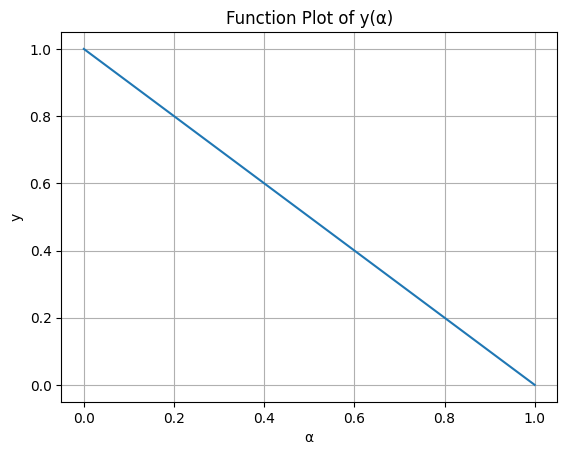

In [62]:
Alpha_np = Alpha.numpy()
alpha_y_np = alpha_y.numpy()
plt.plot(Alpha_np, alpha_y_np)
plt.xlabel('α')
plt.ylabel('y')
plt.title('Function Plot of y(α)')
plt.grid(True)
plt.show()

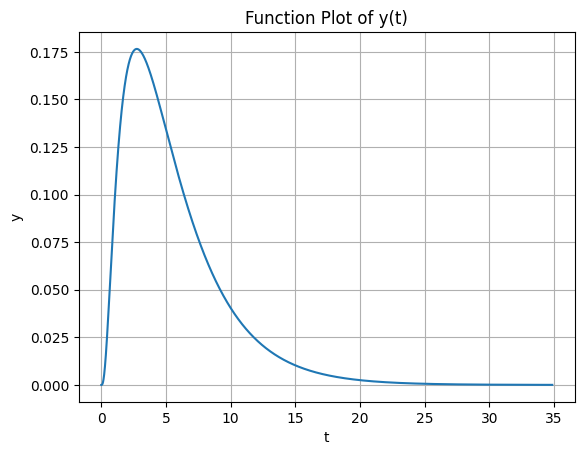

In [63]:
T_np = T.numpy()
t_y_np = t_y.numpy()
plt.plot(T_np, t_y_np)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Function Plot of y(t)')
plt.grid(True)
plt.show()

In [64]:
# def normalize(X, y):
#     X_min = X.min()
#     X_max = X.max()
#     X_norm = (X - X_min) / (X_max - X_min)

#     y_min = y.min()
#     y_max = y.max()
#     y_norm = (y - y_min) / (y_max - y_min)

#     return X_norm, y_norm

In [65]:
# T, t_y = normalize(T, t_y)

In [66]:
# T_np = T.numpy()
# t_y_np = t_y.numpy()
# plt.plot(T_np, t_y_np)
# plt.xlabel('t')
# plt.ylabel('y')
# plt.title('Function Plot of y(t)')
# plt.grid(True)
# plt.show()

## Train-test datasets split

In [67]:
alpha_train, alpha_test, ya_train, ya_test = train_test_split(Alpha, alpha_y, test_size=0.1) # 10% from Lloyd's at all. "Using..."
t_train, t_test, yt_train, yt_test = train_test_split(T, t_y, test_size=0.1)

In [68]:
alpha_train.shape, alpha_test.shape, ya_train.shape, ya_test.shape

(torch.Size([900, 1]),
 torch.Size([100, 1]),
 torch.Size([900, 1]),
 torch.Size([100, 1]))

In [69]:
t_train.shape, t_test.shape, yt_train.shape, yt_test.shape

(torch.Size([3136, 1]),
 torch.Size([349, 1]),
 torch.Size([3136, 1]),
 torch.Size([349, 1]))

## Model 1 (alpha_model)

### Hyperparams for the NN alpha_model (for function 1.1)

In [70]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 10000

### alpha_model definition, compilation and training

In [71]:
alpha_model = MLP(hidden_size)

criterion = nn.MSELoss()
alpha_optimizer = optim.Adam(alpha_model.parameters(), lr=learning_rate)

alpha_train_history = train_model(alpha_model, criterion, alpha_optimizer, alpha_train, ya_train, num_epochs)

summary(alpha_model, (1,)) # (1, ) - input shape

Epoch [100/10000], Loss: 0.0757339597
Epoch [200/10000], Loss: 0.0657043457
Epoch [300/10000], Loss: 0.0555136651
Epoch [400/10000], Loss: 0.0448825993
Epoch [500/10000], Loss: 0.0340080746
Epoch [600/10000], Loss: 0.0235565864
Epoch [700/10000], Loss: 0.0145399924
Epoch [800/10000], Loss: 0.0078317402
Epoch [900/10000], Loss: 0.0036615839
Epoch [1000/10000], Loss: 0.0015383145
Epoch [1100/10000], Loss: 0.0006562577
Epoch [1200/10000], Loss: 0.0003525096
Epoch [1300/10000], Loss: 0.0002615940
Epoch [1400/10000], Loss: 0.0002343935
Epoch [1500/10000], Loss: 0.0002230505
Epoch [1600/10000], Loss: 0.0002149939
Epoch [1700/10000], Loss: 0.0002074774
Epoch [1800/10000], Loss: 0.0002000173
Epoch [1900/10000], Loss: 0.0001925634
Epoch [2000/10000], Loss: 0.0001851310
Epoch [2100/10000], Loss: 0.0001777397
Epoch [2200/10000], Loss: 0.0001704060
Epoch [2300/10000], Loss: 0.0001631445
Epoch [2400/10000], Loss: 0.0001559663
Epoch [2500/10000], Loss: 0.0001488816
Epoch [2600/10000], Loss: 0.000141

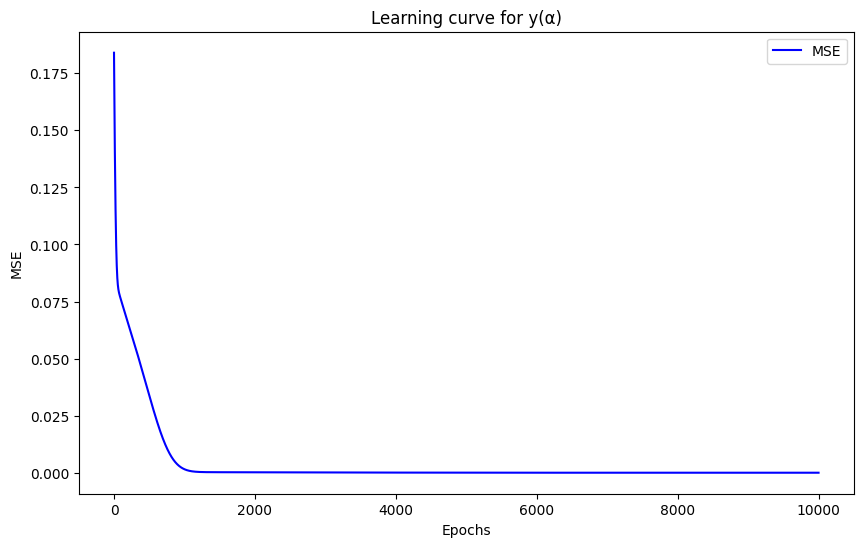

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(alpha_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(α)')
plt.legend()
plt.grid(False)
plt.show()

### alpha_model testing

In [73]:
alpha_test_loss = test_model(alpha_model, criterion, alpha_test, ya_test)
print(f"Test Loss: {alpha_test_loss:.10f}")

Test Loss: 0.0000016033


## alpha_model usage

In [74]:
bs1, we1, bs2, we2 = extract_model_params(alpha_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [75]:
nn_alpha = get_NN_integral(a1, b1, bs1, we1, bs2, we2)

nn_alpha

array([mpf('0.50000621199156492')], dtype=object)

It's easy to get this integral analytically $\int d\alpha \{1 - \alpha\} = \alpha - \frac{\alpha^2}{2}$, so the actual definite integral value is:

In [76]:
def int_alpha(a, b):
    return b - b**2/2 - (a - a**2/2)

alpha_actual = int_alpha(0, 1)

alpha_actual

0.5

And the error is:

In [77]:
nn_alpha = float(nn_alpha[0]) # since there should be one value of the definite integral

abs(nn_alpha - alpha_actual)

6.211991564919472e-06

## Model 2 (t_model)

### Hyperparams for the NN t_model (for function 1.2)

In [78]:
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### t_model definition, compilation and training

In [79]:
t_model = MLP(hidden_size)

criterion = nn.MSELoss()
t_optimizer = optim.Adam(t_model.parameters(), lr=learning_rate)

t_train_history = train_model(t_model, criterion, t_optimizer, t_train, yt_train, num_epochs)

summary(t_model, (1,)) # (1, ) - input shape

Epoch [100/5000], Loss: 0.0067664231
Epoch [200/5000], Loss: 0.0010189409
Epoch [300/5000], Loss: 0.0005168605
Epoch [400/5000], Loss: 0.0002222326
Epoch [500/5000], Loss: 0.0000898315
Epoch [600/5000], Loss: 0.0000470404
Epoch [700/5000], Loss: 0.0000334509
Epoch [800/5000], Loss: 0.0000271445
Epoch [900/5000], Loss: 0.0000228926
Epoch [1000/5000], Loss: 0.0000195669
Epoch [1100/5000], Loss: 0.0000168812
Epoch [1200/5000], Loss: 0.0000147058
Epoch [1300/5000], Loss: 0.0000129448
Epoch [1400/5000], Loss: 0.0000115185
Epoch [1500/5000], Loss: 0.0000103603
Epoch [1600/5000], Loss: 0.0000094150
Epoch [1700/5000], Loss: 0.0000086379
Epoch [1800/5000], Loss: 0.0000079926
Epoch [1900/5000], Loss: 0.0000074503
Epoch [2000/5000], Loss: 0.0000069879
Epoch [2100/5000], Loss: 0.0000065869
Epoch [2200/5000], Loss: 0.0000062332
Epoch [2300/5000], Loss: 0.0000059157
Epoch [2400/5000], Loss: 0.0000056260
Epoch [2500/5000], Loss: 0.0000053581
Epoch [2600/5000], Loss: 0.0000051074
Epoch [2700/5000], Lo

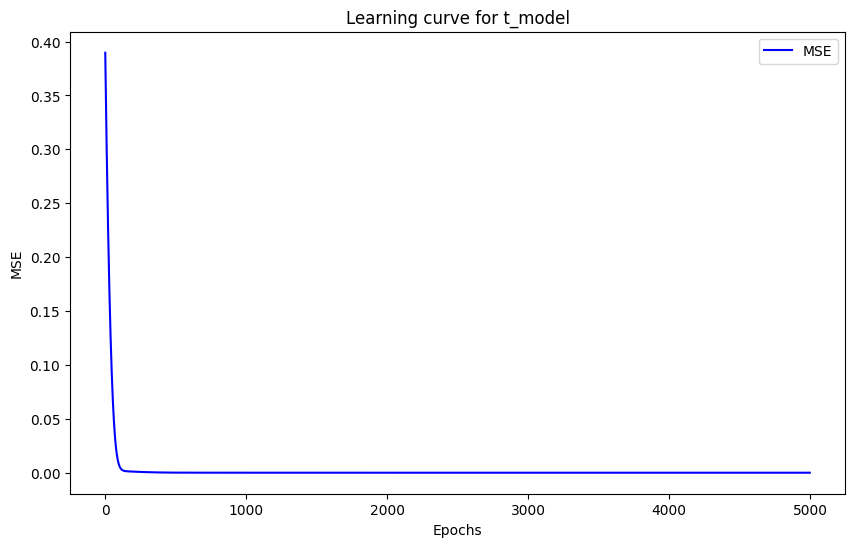

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(t_train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for t_model')
plt.legend()
plt.grid(False)
plt.show()

### t_model testing

In [81]:
t_test_loss = test_model(t_model, criterion, t_test, yt_test)
print(f"Test Loss: {t_test_loss:.10f}")

Test Loss: 0.0000025091


## t_model usage

In [82]:
bs1, we1, bs2, we2 = extract_model_params(t_model)
bs1.shape, we1.shape, bs2.shape, we2.shape

((10,), (10,), (1,), (10,))

In [83]:
nn_t = get_NN_integral(a2, b2, bs1, we1, bs2, we2)

nn_t

array([mpf('1.2106168593510942')], dtype=object)

In [84]:
nn_t = float(nn_t[0])

## Result 2

In [85]:
result2 = nn_alpha * nn_t

result2

0.6053159500172658

In [86]:
correct_result2 = 0.5979058
error_for_result2 = abs(result2 - correct_result2)
error_for_result2

0.007410150017265749